# Dome Azimuth From Telescope Orientation

In [1]:
%matplotlib inline
import numpy as np
import numpy.linalg as la

# Plotting
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns

# Either one of the following imports needs to be used! (1) Linux (2) W10
# from matplotlib_inline.backend_inline import set_matplotlib_formats
from IPython.display import set_matplotlib_formats

from mpl_toolkits.mplot3d import Axes3D

# Plotting settings
set_matplotlib_formats('png', 'pdf')

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.5})

# For astro conversions
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy import units as u
import datetime

## Modelling The Telescope Pointing

Relevant dimensions/constants (in meters unless otherwise stated):

In [2]:
# Telescope:
l_1 = 0.806 # distance floor-HA axis
l_2 = 1.326 # distance HA axis-Dec axis
l_3 = 0.424 # distance Dec axis-tube center

aperture_r = 0.2 # m

# Dome:
d = 6.5   # diameter
r = d/2   # radius
e = 1.76  # extent of cylindrical dome wall
h = r + e # height of half capsule repr. dome
w = 1.84  # Slit width

# Obvervatory:
lat = 53.24 # degrees

Defining the transformation matrices:

In [3]:
def vec(x, y, z):
    return np.array([x, y, z, 1]).reshape((4,1))

def trans(x, y, z):
    return np.array([
        [1, 0, 0, x],
        [0, 1, 0, y],
        [0, 0, 1, z],
        [0, 0, 0, 1],
    ])

def rot_x(angle):
    angle = np.radians(angle)
    return np.array([
        [1,             0,              0, 0],
        [0, np.cos(angle), -np.sin(angle), 0],
        [0, np.sin(angle),  np.cos(angle), 0],
        [0,             0,              0, 1],
    ])

def rot_y(angle):
    angle = np.radians(angle)
    return np.array([
        [np.cos(angle),  0,  -np.sin(angle), 0],
        [0,              1,               0, 0],
        [-np.sin(angle), 0,   np.cos(angle), 0],
        [0,              0,               0, 1],
    ])

def rot_z(angle):
    angle = np.radians(angle)
    return np.array([
        [np.cos(angle),  -np.sin(angle), 0, 0],
        [np.sin(angle),  np.cos(angle), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ])

Compute the position of the telescope back plate with `get_transform` and `telescope_pos`.

In [48]:
def get_transform(ha, dec, x=0, y=-0.5, z=0):
    H_01 = trans(0, 0, l_1)
    H_12 = rot_x(90-lat) @ rot_z(ha) @ trans(0, 0, l_2)
    H_23 = rot_x(dec) @ trans(-l_3, 0, 0)
    H_34 = trans(x, y, z)
    
    H = H_01 @ H_12 @ H_23 @ H_34
    
    return H

def telescope_pos(ha=0, dec=0):
    """
    Compute the position of the
    telescope in the dome.
    """
    origin = vec(0, 0, 0)
    pose_matrix = get_transform(ha, dec, y=0)
    
    return pose_matrix @ origin

# def get_aperture(ha, dec, x, z):
#     """
#     Compute a position in the
#     aperture of the telescope.
#     """
#     origin = vec(0, 0, 0)
#     pose_matrix = get_transform(ha, dec, x=x, y=0, z=z)
    
#     return pose_matrix @ origin

def get_aperture(ha, dec, x, z):
    """
    Compute a position in the
    aperture of the telescope.
    """
    y = np.zeros(x.size)
    dummy = np.ones(x.size)
    points = np.column_stack((x, y, z, dummy))

    pose_matrix = get_transform(ha, dec, x=0, y=0, z=0)
    product = points @ pose_matrix.T
    
    return product[:, :3]

## Telescope in dome frame

Compute the origin of each consecutive reference frame with `get_origins`.

In [30]:
def get_origins(ha, dec, y_back=-0.3):
    """Compute the origin of each intermediate ref. frame."""
    origin = vec(0, 0, 0)
    H_01 = trans(0, 0, l_1)
    H_12 = rot_x(90-lat) @ rot_z(ha) @ trans(0, 0, l_2)
    H_23 = rot_x(dec) @ trans(-l_3, 0, 0)
    H_34 = trans(0, y_back, 0)
    H_45 = trans(0, -3*y_back, 0)
    
    pose_0 = origin # Dome origin
    pose_1 = H_01 @ origin # RA axis origin
    pose_2 = H_01 @ H_12 @ origin # Dec axis origin
    pose_3 = H_01 @ H_12 @ H_23 @ origin # Center aperture
    pose_4 = H_01 @ H_12 @ H_23 @ H_34 @ origin # Back aperture
    pose_5 = H_01 @ H_12 @ H_23 @ H_34 @ H_45 @ origin # Front aperture

    return np.array([pose_0, pose_1,pose_2,pose_3,pose_4, pose_5])

def get_direction(p1, p2):
    d = p2 - p1
    d_unit = d/la.norm(d)
    
    return d_unit

To calculate the dome azimuth, using `atan2`, we require a conversion function. Assuming we assume the azimuth to be 0 north and increasing in the eastward direction.

In [31]:
def compute_azimuth(x, y):
    """
    Return the azimuth (rad) using
    the north clockwise conv.
    """
    az = np.arctan2(x, y) # note (x,y) rather than (y,x)
    
    if az < 0:
        az += 2*np.pi
    
    return az

## Dome Azimuth

In [32]:
class Capsule:
    def __init__(self, radius, extent, center_x=0, center_y=0, center_z=0):
        self.r = radius
        self.e = extent
        self.c = np.array([center_x, center_y, center_z])
        
    def get_radius(self):
        return self.r
    
    def get_extent(self):
        return self.e
    
    def get_center(self):
        return self.c
    
class Vector:
    def __init__(self, x=0, y=0, z=0):
        self.x = x
        self.y = y
        self.z = z
        self.array = np.array([x, y, z])
        
    def get_x(self):
        return self.x
        
    def get_y(self):
        return self.y
        
    def get_z(self):
        return self.z
    
    def get_array(self):
        return self.array

In [33]:
def find_intersection(point, direction, capsule):
    has_intersection = False
    t = None
    
#     if direction.z < 0:
#         return has_intersection, t
    
    if np.isclose(direction.x, 0) and np.isclose(direction.y, 0):
        z = e + np.sqrt(capsule.r**2 - point.x**2 - point.y**2)
        t = z - point.z
        
        has_intersection = True
        return has_intersection, t
    
    # If the direction vector is not (nearly) parallel to 
    # the z-axis of the capsule
    a2 = direction.x**2 + direction.y**2
    a1 = point.x*direction.x + point.y*direction.y
    a0 = point.x**2 + point.y**2 - capsule.r**2
    
    delta = a1**2-a0*a2
    t     = (-a1+np.sqrt(delta))/a2
    
    if point.z + t * direction.z >= capsule.e:
        a0 = point.x**2 + point.y**2 + (point.z-capsule.e)**2 - capsule.r**2
        a1 = point.x*direction.x + point.y*direction.y + (point.z-capsule.e)*direction.z
        
        t = -a1+np.sqrt(a1**2-a0)
    
    if t:
        has_intersection = True
    
    return has_intersection, t

def get_ray_intersection(p, d, t):
    return p.get_array() + t*d.get_array()

## Telescope-Dome Model

**Note:** To use the nort-clockwise convension to calculate the azimuth angle, use `atan2(x, y)` rather than `atan2(y, x)`, which gives the angle in an east-counterclockwise manner.

In [34]:
ha = np.linspace(-180, 180, 100)
dec = np.linspace(-90, 90, 100)

In [35]:
def get_dome_azimuth(ha, dec, dome, print_result=False):
    """
    Using the HA/Dec angles, compute
    the azimuth of the dome.
    
    Returns a tuple (az, STATUS):
    - STATUS = 0 -> Error
    - STATUS = 1 -> Succes
    """
    az    = 0
    STATUS = 1

    # Get the origins of each ref. frame 
    os = get_origins(ha, dec)[:,:3].reshape(6, 3)

    # Compute dome intersection
    tube_center = os[[3,5]][0]
    direction = Vector(*get_direction(tube_center, os[[3,5]][1]))
    p = Vector(*tube_center)

    try:
        has_intersection, t = find_intersection(p, direction, dome)

        if has_intersection:
            p_s = get_ray_intersection(p, direction, t)
            os = np.concatenate([os, [p_s]])

            az = compute_azimuth(p_s[0], p_s[1])
            
            if print_result:
                print('Az =', np.degrees(az),'degrees')
    except:
        STATUS = 0
    
    return np.degrees(az)

get_az = np.vectorize(get_dome_azimuth)

## Disk Sampling

See [mathworld's disk point picking article](https://mathworld.wolfram.com/DiskPointPicking.html).

In [38]:
def uniform_disk(r, n):
    radii  = np.random.uniform(0, 1, n)
    angles = np.random.uniform(0, 2*np.pi, n)
    
    x = np.sqrt(radii) * np.cos(angles)
    y = np.sqrt(radii) * np.sin(angles)
    
    xy = r*np.column_stack([x, y])
    
    return xy

def equidistant_disk(r, n):
    delta_r = 1/n
    radii = np.arange(0, 1 + delta, delta)
    
    # DO STUFF; See http://www.holoborodko.com/pavel/2015/07/23/generating-equidistant-points-on-unit-disk/
    
    xy = None
    
    return xy

Compute the intersection of the rays with the dome:

In [39]:
# def get_pointing_direction(ha, dec):
#      # Get the origins of each ref. frame 
#     os = get_origins(ha, dec)[:,:3].reshape(6, 3)

#     # Compute dome intersection
#     tube_center = os[[3,5]][0]
#     direction = Vector(*get_direction(tube_center, os[[3,5]][1]))
    
#     return direction

def semi_intersection(elev, w, r):
    k = np.power(r*np.cos(elev), 2) - np.power(w/2, 2)
    
    # INTRODUCE PROPER SOLUTION!!!
    if k < 0:
        print('Hello neg sqrt here! discriminant =', k, ', (w/2)^2 =', np.power(w/2, 2), ', r*cos(elev) =', r*np.cos(elev))
        return 0
    
    return np.sqrt(k)

def get_semi_az(p, dome):
    elev = np.arctan2(p[2] - dome.e, np.sqrt(p[0]**2 + p[1]**2))
    
#     print('elev', np.degrees(elev), ', (x,y) = (', p[0], p[1], ')')
    
    y = semi_intersection(elev, w, dome.r)
    x = w/2
    delta = np.pi/2 - np.arctan2(y, x)
    
    return delta

def is_blocked(origin, ha, dec, dome_az, dome):
    """
    Return True when the given ray in the aperture is blocked.
    """
    is_b = True
    
    p = Vector(*origin.reshape(3))
    
    # Get the origins of each ref. frame 
    os = get_origins(ha, dec)[:,:3].reshape(6, 3)

    # Compute dome intersection
    tube_center = os[[3,5]][0]
    direction = Vector(*get_direction(tube_center, os[[3,5]][1]))

    try:
        has_intersection, t = find_intersection(p, direction, dome)

        if has_intersection:
            p_s = get_ray_intersection(p, direction, t)
            
            ray_az = np.degrees(compute_azimuth(p_s[0], p_s[1]))
            slit_offset = np.degrees(get_semi_az(p_s, dome))
            slit_az_min = dome_az - slit_offset + 360 
            slit_az_max = dome_az + slit_offset
            
            is_ray_in_slit = ray_az > slit_az_min or ray_az < slit_az_max

#             print('ray az   = {:.2f} deg'.format(ray_az))
#             print('slit     = {:.2f} +/- deg'.format(dome_az, slit_offset))
#             print('slit min = {:.2f} deg; slit max = {:.2f}'.format(slit_az_min, slit_az_max))
            
            if p_s[2] > dome.e and is_ray_in_slit:
                is_b = False
            
    except Exception as ex:
        print(str(ex))
    
#     print('height', os[3][2])
#     print('p_z =', p_s[2], 'vs.', 'e =', e)
    
    return is_b

Uniformly sample the aperture:

In [40]:
ap_xz = uniform_disk(aperture_r, 5000)
ap_x, ap_z = ap_xz.T

Plot the point distribution, looking down the aperture of the telescope:

In [41]:
# fig = plt.figure(figsize=(4, 4))
# frame = fig.add_subplot(1, 1, 1)

# frame.plot(ap_x, ap_z, ls='', marker='o', ms=3, color='black')

# frame.set_xlabel(r'$x$', fontsize=18)
# frame.set_ylabel(r'$z$', fontsize=18)
# frame.grid(ls='--', alpha=0.5)

# frame.set_ylim(-2*aperture_r, 2*aperture_r)
# frame.set_xlim(-2*aperture_r, 2*aperture_r)

# plt.show()

Specify the HA/Dec of the telescope & Az of the dome... In DEGREES...

In [42]:
ha_test = 0 #36
dec_test = -40 #24
az_test = 0 #250

Compute the origin of the uniformly sampled aperture:

In [52]:
# ap_pos = []

# for x, z in zip(ap_x, ap_z):
#     p = get_aperture(ha_test, dec_test, -x, z)
#     ap_pos.append(p)
    
# ap_pos = np.array(ap_pos)
# ap_pos = ap_pos[:, :3]

In [54]:
ap_pos = get_aperture(ha_test, dec_test, -ap_x, ap_z)
# ap_pos = []

# for x, z in zip(ap_x, ap_z):
#     p = get_aperture(ha_test, dec_test, -x, z)
#     ap_pos.append(p)
    
# ap_pos = np.array(ap_pos)
# ap_pos = ap_pos[:, :3]

# ap_pos = np.stack(get_aperture(ha_test, dec_test, -ap_x, ap_z))

In [21]:
dome  = Capsule(r, e)
# d = get_pointing_direction(0, -60)

Compute the blocked rays:

In [55]:
blocked = []

for p in ap_pos:
    b = is_blocked(p, ha_test, dec_test, az_test, dome)
    blocked.append(b)

blocked = np.array(blocked)

print('Aperture blockage = {:.2%}'.format(blocked[blocked].size/blocked.size))

Aperture blockage = 84.74%


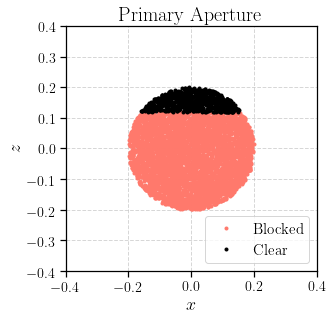

In [56]:
fig = plt.figure(figsize=(4.5, 4.5))
frame = fig.add_subplot(1, 1, 1)

frame.plot(ap_x[blocked], ap_z[blocked], ls='', marker='o', ms=3, color='xkcd:salmon', label='Blocked')
frame.plot(ap_x[~blocked], ap_z[~blocked], ls='', marker='o', ms=3, color='black', label='Clear')

frame.set_xlabel(r'$x$', fontsize=18)
frame.set_ylabel(r'$z$', fontsize=18)
frame.grid(ls='--', alpha=0.5)

frame.set_ylim(-2*aperture_r, 2*aperture_r)
frame.set_xlim(-2*aperture_r, 2*aperture_r)

frame.set_title('Primary Aperture', fontsize=20)

frame.legend(fontsize=15, loc='lower right')

plt.show()